# Car Price prediction

### Прогнозирование стоимости автомобиля по характеристикам

In [ ]:
!pip install PyDrive -q

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Imports and Settings

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install -q tensorflow==2.3

# аугментации изображений
!pip install -q git+https://github.com/albu/albumentations.git --no-cache-dir

!pip install catboost -q

     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 460kB 48.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 952kB 4.2MB/s 
     |████████████████████████████████| 66.3MB 57kB/s 


In [ ]:
import zipfile

import numpy as np
import pandas as pd
import os
import sys
import re
import random
import PIL
import cv2
from datetime import timedelta, datetime as dt
from time import time


from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import albumentations

# plt
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
# Улучшим вид графиков в svg
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.19.4
Tensorflow   : 2.3.0
Keras        : 2.4.0


In [ ]:
# фиксируем RANDOM_SEED и библиотеки
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

!pip freeze > requirements.txt

In [ ]:
# функция для рассчета MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

# DATA

Типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [ ]:
downloaded = drive.CreateFile({'id':"1M4IasI_WNkCegkvoR2CBQH7kaLiqsUzm"})
downloaded.GetContentFile('img.zip') 
downloaded = drive.CreateFile({'id':"12PhQNWPc1embi6cJqyZYsmDeD-OcwsRs"})
downloaded.GetContentFile('test.csv') 
downloaded = drive.CreateFile({'id':"18moKLhD5ZFW30rvOWMAdKiBkEk0u3Kuh"})
downloaded.GetContentFile('train.csv') 
downloaded = drive.CreateFile({'id':"1ggI9TLGsVXe8Ndr2wwVzZEb_smzmGQdD"})
downloaded.GetContentFile('sample_submission.csv')

print(os.listdir("."))

['.config', 'test.csv', 'adc.json', 'sample_submission.csv', 'train.csv', 'requirements.txt', 'img.zip', 'sample_data']


In [ ]:
DATA_DIR = ''
WORK_DIR = 'working/'

print('Распаковываем картинки.. ', end='')
for data_zip in ['img.zip']:
    with zipfile.ZipFile(DATA_DIR + data_zip, "r") as z:
        z.extractall(DATA_DIR)
print('Готово')

if not os.path.exists(WORK_DIR):
  os.mkdir(WORK_DIR)
print(os.listdir())

# Подгружаем данные, сразу отсекая возможные дубликаты в train
train = pd.read_csv(DATA_DIR + 'train.csv').drop_duplicates()
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

Распаковываем картинки.. Готово
['.config', 'test.csv', 'adc.json', 'sample_submission.csv', 'train.csv', 'working', 'img', 'requirements.txt', 'img.zip', 'sample_data']


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [ ]:
# split данных
data_train, data_test = train_test_split(train, 
                                         test_size=0.15, 
                                         shuffle=True, 
                                         random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним ненайденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(f'Точность наивной модели по метрике MAPE:', 
      f"{(mape(data_test['price'], predicts.values[:, 0])) * 100: .2f}%")

Точность наивной модели по метрике MAPE:  19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Начнем с того, что напишем базовые функции для обработки признаков:

In [ ]:
# Обработка признака "Владение"
def proc_ownership(row):
    if pd.isnull(row): 
        return np.nan
    row = row.split()
    l = []
    i = len(row) - 1
    while i >= 0:
        if 'лет' in row[i] or 'год' in row[i]:
            l.append(int(row[i - 1]) * 12)
            i -= 1
        elif row[i].isnumeric():
            l.append(int(row[i]))
        i -= 1
    return sum(l)

# Обработка признака "engineDisplacement"
def proc_engineDisplacement(row):
    row = row[:-4]
    return float(row) if row != 'undefined' else np.nan

# Обработка признака "enginePower"
def proc_enginePower(row):
    return int(row[:-4])

# Обработка признака "name"
def proc_name(row):
    # удаляем информацию enginePower
    row = re.sub('[(].*[)]', '', row)
    # удаляем информацию engineDisplacement
    row = re.sub('\d\.\dd*', '', row)
    # удаляем информацию vehicleTransmission
    row = re.sub('(\sAT)|(\sCVT)|(\sAMT)|(\sMT)', '', row)
    return row


# Проверим работу функций преобразований
print(train['Владение'].apply(proc_ownership).unique()[:5])
print(train['engineDisplacement'].apply(proc_engineDisplacement).unique()[:5])
print(train['enginePower'].apply(proc_enginePower).unique()[:5])
print(train['name'].apply(proc_name).unique()[:5])

[ nan 102.  57.  33.  81.]
[3.  2.8 3.5 2.  1.8]
[272 204 306 180 160]
['530xi   4WD' ' ' '350   4WD' '200  ' '200   4WD']


Train set:


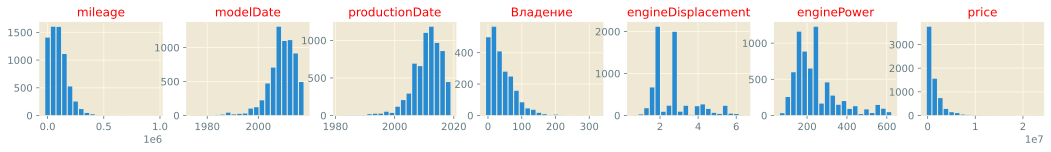

In [ ]:
# Посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(width, titles_values_dict):
    columns = min(width, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 18 / width, rows * 12 / width))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.8)
        ax.set_title(title, color='red', fontsize=16 + 3 - width)
    plt.show()
   
print('Train set:')
visualize_distributions(7, {
    'mileage': train['mileage'], 
    'modelDate': train['modelDate'], 
    'productionDate': train['productionDate'], 
    
    'Владение': train['Владение'].apply(proc_ownership).dropna(), 
    'engineDisplacement': train['engineDisplacement'].apply(proc_engineDisplacement).dropna(), 
    'enginePower': train['enginePower'].apply(proc_enginePower).dropna(), 
    
    'price': train['price'].dropna()
})

Test set:


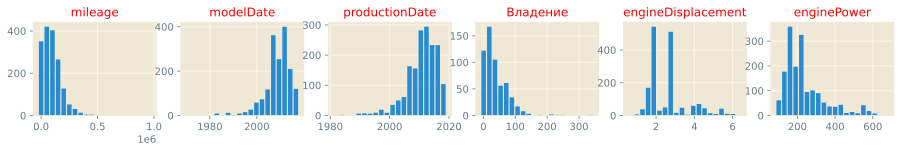

In [ ]:
print('Test set:')
visualize_distributions(7, {
    'mileage': test['mileage'], 
    'modelDate': test['modelDate'], 
    'productionDate': test['productionDate'], 
    
    'Владение': test['Владение'].apply(proc_ownership).dropna(), 
    'engineDisplacement': test['engineDisplacement'].apply(proc_engineDisplacement).dropna(), 
    'enginePower': test['enginePower'].apply(proc_enginePower).dropna()
})

CatBoost сможет работать с признаками и в таком виде, но для нейросети понадобятся нормированные данные.


# PreProc Tabular Data

In [ ]:
# Для корректной обработки признаков объединяем train и test в один датасет
train['sample'] = 1 # маркер для train
test['sample'] = 0 # маркер для test
test['price'] = 0 # target-переменная

# Объединяем train и test:
data = test.append(train, sort=False).reset_index(drop=True)
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')
print(f'data shape: {data.shape}')

train shape: (6682, 23)
test shape: (1671, 23)
data shape: (8353, 23)


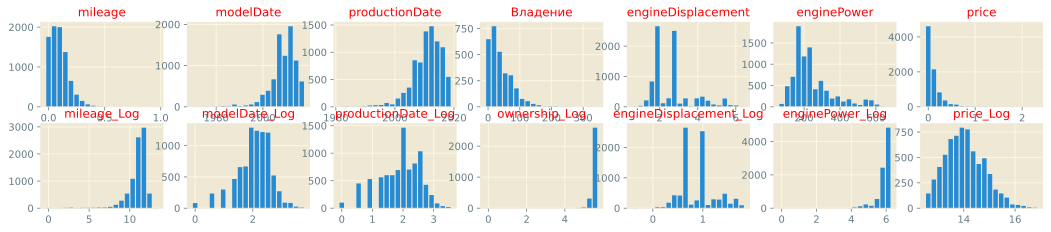

In [ ]:
# В нейросеть желательно подавать данные с распределением, близким к нормальному, 
# поэтому от некоторых числовых признаков имеет смысл перед нормализацией взять логарифм. 
# Посмотрим, как изменится распределение признаков в результате их логарифмирования:

x = data['mileage']
x = np.log(x)
mileage_Log = x

x = data['modelDate']
x = np.log(max(x) + 1 - x)
modelDate_Log = x

x = data['productionDate']
x = np.log(max(x) + 1 - x)
productionDate_Log = x

x = data['Владение'].apply(proc_ownership).dropna()
x = np.log(max(x) + 1 - x)
ownership_Log = x

x = data['engineDisplacement'].apply(proc_engineDisplacement)
x.fillna(x.median(), inplace=True)
x = np.log(x)
engineDisplacement_Log = x

x = data['enginePower'].apply(proc_enginePower)
x = np.log(max(x) + 1 - x)
enginePower_Log = x

x = data[data['sample'] != 0]['price']
x = np.log(x)
price_Log = x


visualize_distributions(7, {
    'mileage': data['mileage'], 
    'modelDate': data['modelDate'], 
    'productionDate': data['productionDate'], 
    'Владение': data['Владение'].apply(proc_ownership).dropna(), 
    'engineDisplacement': data['engineDisplacement'].apply(proc_engineDisplacement).dropna(), 
    'enginePower': data['enginePower'].apply(proc_enginePower), 
    'price': data['price'], 
    
    'mileage_Log': mileage_Log, 
    'modelDate_Log': modelDate_Log, 
    'productionDate_Log': productionDate_Log, 
    'ownership_Log': ownership_Log, 
    'engineDisplacement_Log': engineDisplacement_Log, 
    'enginePower_Log': enginePower_Log, 
    'price_Log': price_Log
})

In [ ]:
# Проверим, в каких числовых признаках есть NaN-значения и нули, 
# и, соответственно, есть ли смысл специально их обрабатывать:

features = [data['mileage'], data['modelDate'], data['productionDate'], 
            data['Владение'].apply(proc_ownership), 
            data['engineDisplacement'].apply(proc_engineDisplacement), 
            data['enginePower'].apply(proc_enginePower), 
            data['price']]

print('__NaN presence__:')
for f in features:
    x = f.isna()
    s = f'{x.any()}'
    if x.any():
        s += f'({x[x == True].count()})'
    print(f'{s} : {f.name}')
    
print()

print('__Zeros presence__:')
for f in features:
    x = f == 0
    s = f'{x.any()}'
    if x.any():
        s += f'({x[x == True].count()})'
    print(f'{s} : {f.name}')

# У признака "Владение" очень много NaN-значений, далее попробуем предсказать их

__NaN presence__:
False : mileage
False : modelDate
False : productionDate
True(5418) : Владение
True(6) : engineDisplacement
False : enginePower
False : price

__Zeros presence__:
False : mileage
False : modelDate
False : productionDate
False : Владение
False : engineDisplacement
False : enginePower
True(1671) : price


In [ ]:
# Посмотрим на цены
pr = data[data['price'] != 0]['price']
print(pr.unique()[:50])
pr[pr % 1000 != 0].count()

# в основном цены имеют значение, кратное 1000, значит, стоит 
# округлять предсказания. Учтем это в дальнейшем

[ 599000.  850000. 1325000.  815000.  810000.  550000. 3170000. 2900000.
 1290000. 1427000. 2370000.  930000. 3700000.  773999. 1317000.  449000.
  980000. 1380000. 1900000. 1100000.  820000.  999000.  910000. 1730000.
  385000.  830000.  757000. 1550000. 2246000. 2349000.  543000. 1850000.
 1500000. 1160000. 1130000. 2550000. 1075000.  670000. 5950000.  840000.
 1300000. 1740000.  450000. 1320000. 1200000. 1349000. 9500000. 1199000.
 1158000. 2450000.]


277

### Preprocessing Function

In [ ]:
def preproc_data(df_input, log_price=False, scale_price=False):
    '''
    Функция производит препроцессинг всех данных: cleansing, converting,
    feature engineering, encoding, normalizing..
    Через параметры можно определить, делать ли логарифмирование и 
    нормализацию таргета, т.е. цены.
    '''
    # Категориальные признаки
    categorical_features = ['bodyType', 'brand', 'color', 
                            'fuelType', 'model_info', 'name', 
                            'numberOfDoors', 'vehicleTransmission', 
                            'Владельцы', 'ПТС', 'Привод', 'Руль']

    # Числовые признаки
    numerical_features = ['mileage', 'modelDate', 'productionDate', 
                          'Владение', 'engineDisplacement', 'enginePower']
    
    if scale_price:
        numerical_features.append('price')
    
    df_output = df_input.copy()

    # ################### Preprocessing ####################
    # убираем ненужные признаки
    df_output.drop(['description', 'sell_id', 'vehicleConfiguration'], 
                   axis=1, inplace=True)
    
    # ################ Numerical Features ##################    
    #--- modelDate
    x = df_output['modelDate']
    x = np.log(max(x) + 1 - x)
    df_output['modelDate'] = x
    
    #--- productionDate
    x = df_output['productionDate']
    x = np.log(max(x) + 1 - x)
    df_output['productionDate'] = x

    #--- Владение
    x = df_output['Владение'].apply(proc_ownership)
    x = np.log(max(x) + 1 - x)
    df_output['Владение'] = x.values.reshape(-1, 1)
    
    #--- engineDisplacement
    x = df_output['engineDisplacement'].apply(proc_engineDisplacement)
    x = x.fillna(x.median())
    x = np.log(x)
    df_output['engineDisplacement'] = x.values.reshape(-1, 1)
        
    #--- enginePower
    x = df_output['enginePower'].apply(proc_enginePower)
    x = np.log(x)
    df_output['enginePower'] = x.values.reshape(-1, 1)
    
    #--- price
    if log_price:
        x = df_output['price']
        x = x.apply(lambda row: np.log(row) if row != 0 else np.nan)
        df_output['price'] = x.values.reshape(-1, 1)
    
    
    # Нормализация данных
    scaler = MinMaxScaler() 
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])  
    
    
    # ################ Categorical Features ################
    #--- name
    df_output['name'] = df_output['name'].apply(proc_name)

    # выделим ключевые слова в отдельные признаки
    dummy_words = ['4WD', 'xDrive', 'AMG', 'Long', 'd', 'CDI', 'BlueTEC', 
                   'длинный', 'L2', 'TFSI', 'BlueEFFICIENCY', 'si', 
                   'Competition', 'L1', 'S-tronic', 'экстра', 'is', 'hyb', 
                   'L3', '8tiptronic', '4MATIC', 'компактный', 'sd', 
                   'Package', '9G-TRONIC', 'Kompressor', 'ActiveHybri']
    
    for word in dummy_words:
        df_output[word] = df_output['name'].apply(lambda row: 1 if word in row else 0)
        df_output['name'] = df_output['name'].apply(lambda row: row.replace(word, ''))
       
    df_output['name'] = df_output['name'].apply(
        lambda row: ' '.join(row.split()) if isinstance(row, str) else row)

    
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, 
                               columns=categorical_features, 
                               dummy_na=True)
    
    if not scale_price:
        scaler = None
    return df_output, (log_price, scaler)

In [ ]:
# Напишем функцию для обратной конвертации цены после предобработки
def restore_price(price, log_price=False, scaler=None):
    if scaler:
        price = scaler.inverse_transform(price.reshape(-1, 1))
    if log_price:
        price = np.exp(price)
    # округляем цену после её восстановления
    price_rounder = lambda x: round(x / 1000) * 1000
    return np.vectorize(price_rounder)(price.reshape(-1, 1))

### Generate Preprocessed Data

In [ ]:
# Проработка выбросов. Их влияние на конечный результат весьма неоднозначно и 
# их удаление подключается опционально путем раскомментирования

def get_outliers(column, func=lambda x: x):
  feature = data.query('sample == 1')[column].apply(func)
  outliers = feature[feature > feature.mean() + feature.std() * 3].index.values
  return list(outliers)

outliers = []
# outliers += get_outliers('price')
# outliers += get_outliers('mileage')
# outliers += get_outliers('Владение', proc_ownership)
# outliers += get_outliers('engineDisplacement', proc_engineDisplacement)
# outliers += get_outliers('enginePower', proc_enginePower)
outliers = list(set(outliers))

print(f'amount of outliers to drop: {len(outliers)}')

amount of outliers to drop: 0


In [ ]:
# Запускаем и проверяем, что получилось

df_preproc, price_mutator = preproc_data(data.drop(outliers), log_price=False, scale_price=False)
# df_preproc, price_mutator = preproc_data(data.drop(outliers), log_price=True, scale_price=True)
df_preproc.sample(3)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,4WD,xDrive,AMG,Long,d,CDI,BlueTEC,длинный,L2,TFSI,BlueEFFICIENCY,si,Competition,L1,S-tronic,экстра,is,hyb,L3,8tiptronic,4MATIC,компактный,sd,Package,9G-TRONIC,Kompressor,ActiveHybri,BlueEfficiency,All-Terrain,Electro,5G-Tronic,Brabus,...,name_160.0,name_161.0,name_162.0,name_163.0,name_164.0,name_165.0,name_166.0,name_167.0,name_168.0,name_169.0,name_170.0,name_171.0,name_172.0,name_173.0,name_nan,numberOfDoors_0.0,numberOfDoors_1.0,numberOfDoors_2.0,numberOfDoors_3.0,numberOfDoors_nan,vehicleTransmission_0.0,vehicleTransmission_1.0,vehicleTransmission_2.0,vehicleTransmission_3.0,vehicleTransmission_nan,Владельцы_-1.0,Владельцы_0.0,Владельцы_1.0,Владельцы_2.0,Владельцы_nan,ПТС_0.0,ПТС_1.0,ПТС_nan,Привод_0.0,Привод_1.0,Привод_2.0,Привод_nan,Руль_0.0,Руль_1.0,Руль_nan
7399,0.467888,0.529985,0.106999,0.460391,0.489076,0.970765,1,1590000.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
4273,0.467888,0.529985,0.044999,0.500000,0.439310,0.985487,1,3100000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
3362,0.918742,0.919650,0.054999,0.500000,0.489076,NaN,1,3750000.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0


## Predict Ownership
Предсказываем NaN-значения признака "Владение" с помощью CatBoostRegressor

In [ ]:
df_preproc['Владение'].isna().sum()
# видно очень много пустых значений - мы это так не оставим!

5418

In [ ]:
# восстановим до изначальных целых
df_preproc['Владение'] = data['Владение'].apply(proc_ownership)

In [ ]:
# используем важные для признака фичи
ownership_important_features = ['bodyType', 'brand', 'fuelType', 
                                'productionDate', 'mileage', 
                                'price', 'Владельцы']

own_columns = [c for c in df_preproc.columns 
               for f in ownership_important_features 
               if f in c]

df = df_preproc[own_columns + ['Владение', 'sample']].copy()
df.loc[(df['sample'] == 0), 'price'] = np.nan

train_df = df[df['Владение'].isna() == False]
test_df = df[df['Владение'].isna() == True]

y = train_df['Владение'].values
X = train_df.drop(['Владение'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    shuffle=True, 
    random_state=RANDOM_SEED
)

In [ ]:
model = CatBoostRegressor(iterations=3000, 
                          depth=3, 
                          random_seed=RANDOM_SEED, 
                          eval_metric='MAPE', 
                          custom_metric=['RMSE', 'MAE'], 
                          od_wait=500)

model.fit(X_train, y_train, 
          eval_set=(X_test, y_test), 
          verbose_eval=500, 
          use_best_model=True)

Learning rate set to 0.027622
0:	learn: 1.4665549	test: 1.5695077	best: 1.5695077 (0)	total: 915us	remaining: 2.74s
500:	learn: 0.9732362	test: 1.2203622	best: 1.2203622 (500)	total: 429ms	remaining: 2.14s
1000:	learn: 0.9039733	test: 1.2063310	best: 1.2062926 (999)	total: 849ms	remaining: 1.7s
1500:	learn: 0.8709281	test: 1.1924793	best: 1.1918182 (1492)	total: 1.27s	remaining: 1.27s
2000:	learn: 0.8447756	test: 1.1880612	best: 1.1873117 (1975)	total: 1.71s	remaining: 853ms
2500:	learn: 0.8236271	test: 1.1878632	best: 1.1868414 (2387)	total: 2.13s	remaining: 425ms
2999:	learn: 0.8057612	test: 1.1899439	best: 1.1854924 (2792)	total: 2.57s	remaining: 0us

bestTest = 1.185492352
bestIteration = 2792

Shrink model to first 2793 iterations.


In [ ]:
own_pred = np.round(model.predict(X_test))

print(f'TEST mape: {(mape(y_test, own_pred)) * 100: .2f}%')

TEST mape:  118.49%


In [ ]:
# склеим новую колонку и заполним ей предобработанный датафрейм
own_pred = np.round(model.predict(test_df))
test_df = test_df.assign(Владение=own_pred)

new_ownership = pd.concat([train_df['Владение'], 
                           test_df['Владение']])

df_preproc = df_preproc.assign(Владение=new_ownership)
df_preproc['Владение'].isna().sum()

0

In [ ]:
# логарифмируем
x = df_preproc['Владение']
x = np.log(max(x) + 1 - x)
df_preproc['Владение'] = x.values.reshape(-1, 1)

# нормализуем
scaler = MinMaxScaler() 
df_preproc['Владение'] = scaler.fit_transform(df_preproc[['Владение']])

## Split data

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.13, 
    shuffle=True, 
    random_state=RANDOM_SEED
)

# Model 2: CatBoostRegressor

In [ ]:
model = CatBoostRegressor(iterations=10000, 
                          depth=9, 
                          learning_rate=0.035, 
                          random_seed=RANDOM_SEED, 
                          eval_metric='MAPE', 
                          custom_metric=['RMSE', 'MAE'], 
                          od_wait=700)

model.fit(X_train, y_train, 
          eval_set=(X_test, y_test), 
          verbose_eval=1000, 
          use_best_model=True)

In [ ]:
cat_pred = restore_price(model.predict(X_test), *price_mutator)
cat_test = restore_price(y_test, *price_mutator)
print(f'TEST mape: {(mape(cat_test, cat_pred)) * 100: .2f}%')

TEST mape:  10.60%


### Submission

In [ ]:
sub_predict_catboost = restore_price(model.predict(X_sub), *price_mutator)

sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(WORK_DIR + 'catboost_submission.csv', index=False)

# Model 3: Tabular NN

## Simple Dense NN

In [ ]:
BATCH_SIZE    = 256    # размер Batch
LR            = 0.1    # Learning rate
LR_DECAY_RATE = 0.999  # скорость "распада" Learning rate

In [ ]:
# Определим функцию для создания списка callbacks
def recreate_callbacks(es_patience=10, use_scheduler=True):
    callbacks_list = [# сохранять прогресс обучения модели, чтобы 
                      # позже можно было подгрузить и дообучить модель:
                      ModelCheckpoint(WORK_DIR + 'best_model.hdf5', 
                                      monitor='val_MAPE', 
                                      mode='min', 
                                      save_best_only=True, 
                                      verbose=0), 
                      
                      # останавливать процесс обучения, если целевая 
                      # метрика не улучшается `patience` эпох подряд:
                      EarlyStopping(monitor='val_MAPE', 
                                    patience=es_patience, 
                                    restore_best_weights=True),
                                            
                      # постепенно уменьшать LR после каждой эпохи:
                      LearningRateScheduler(lambda x: LR * LR_DECAY_RATE ** x, 
                                            verbose=0)
                      ]
    if not use_scheduler:
      del callbacks_list[2]
    return callbacks_list

In [ ]:
# Пропишем функцию для пересоздания модели MLP
def rebuild_nn1():
  return Sequential([L.Input(shape=X_train.shape[1]), 
                     L.Dense(512, activation='relu'), 
                     L.BatchNormalization(), 
                     L.Dropout(0.7), 
                     L.Dense(256, activation='relu'), 
                     L.Dropout(0.3), 
                     L.Dense(1, activation="linear")])

In [ ]:
# Создаем и компилируем MLP-модель
model = rebuild_nn1()

optimizer = tf.keras.optimizers.Adamax(LR)
# optimizer = tf.keras.optimizers.Adam(LR, amsgrad=True)

model.compile(loss='MAPE', 
              optimizer=optimizer, 
              metrics=['MAPE'])

### Fit

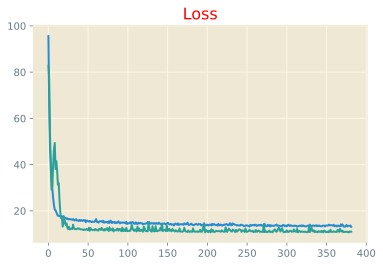

CPU times: user 4min, sys: 13.1 s, total: 4min 13s
Wall time: 2min 25s


In [ ]:
%%time

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=1000, 
                    validation_data=(X_test, y_test), 
                    callbacks=recreate_callbacks(100), 
                    verbose=0)


def plot_history(history):
  plt.title('Loss', color='r')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.show();

plot_history(history)

In [ ]:
model.load_weights(WORK_DIR + 'best_model.hdf5')
model.save(WORK_DIR + 'nn_1.hdf5')


nn1_pred = restore_price(model.predict(X_test), *price_mutator)
nn1_test = restore_price(y_test, *price_mutator)
print(f'TEST mape: {(mape(nn1_test, nn1_pred)) * 100: .2f}%')

TEST mape:  10.72%


In [ ]:
sub_predict_nn1 = restore_price(model.predict(X_sub), *price_mutator)
sample_submission['price'] = sub_predict_nn1
sample_submission.to_csv(WORK_DIR + 'nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [ ]:
# Подключим библиотеку для лемматизации русских слов
!pip install pymorphy2 -q
!pip install pymorphy2-dicts -q
!pip install DAWG-Python -q
import pymorphy2

# Подгрузим список стоп-слов
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 8.2MB 7.0MB/s 
     |████████████████████████████████| 7.1MB 3.8MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Text works

In [ ]:
%%time

morph = pymorphy2.MorphAnalyzer()

odd_words = ['amg', 'bmw', 'c', 'fi', 'gt', 'hegcedh', 'i', 'ii', 'in', 'm', 
             'r19', 's', 'uy07066', 'v', 'гарантия', '·', 'б', 'ваш', 
             'возможна', 'вся', 'всё', 'г', 'гк', 'год', 'д', 'др', 
             'ещё', 'ин', 'информация', 'й', 'км', 'л', 'лет', 'лицо', 'м', 
             'могу', 'можете', 'нам', 'наш', 'ооо', 'оф', 'поехал', 'позвонить', 
             'пр', 'р', 'ряд', 'сел', 'т', 'также', 'тд', 'ти', 'тыс', 'х', 
             'час', 'эл', 'это', 'добрый день']

stop_words = set(stopwords.words("russian") + odd_words)

def proc_description(row):
  result = []
  
  # удаляем все символы кроме букв
  row = re.sub('[\W\d_]', ' ', row)
  # удаляем стоп-слова и лемматизируем
  for w in row.split():
    result.append(morph.parse(w)[0].normal_form)
  result = ' '.join(filter(lambda w: w not in stop_words, result))
  return result


data['description_proc'] = data['description'].apply(proc_description)

CPU times: user 3min 35s, sys: 23.9 ms, total: 3min 35s
Wall time: 3min 36s


In [ ]:
data['description_proc'].head(3)

## Split

In [ ]:
df_descr = data.copy()
df_descr['description'] = df_descr['description_proc']
df_descr.drop('description_proc', axis=1, inplace=True)

# split данных
text_train = df_descr.description.iloc[X_train.index]
text_test = df_descr.description.iloc[X_test.index]
text_sub = df_descr.description.iloc[X_sub.index]

## Tokenizer

In [ ]:
# TOKENIZER
# Максимальное количество слов для использования
MAX_WORDS = 100000
# Максимальное количество слов в каждой последовательности
MAX_SEQUENCE_LENGTH = 256

In [ ]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_descr.description)

In [ ]:
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), 
                                              maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), 
                                             maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), 
                                            maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, 
      text_test_sequences.shape, 
      text_sub_sequences.shape)

### Bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(2, 2), 
                                   min_df=40, 
                                   max_features=MAX_SEQUENCE_LENGTH, 
                                   binary=True)

bow_values = count_vectorizer.fit_transform(data['description_proc'])
bow_feature_names = count_vectorizer.get_feature_names()

count_vector_df = pd.DataFrame(bow_values.toarray(), 
                               columns=bow_feature_names)


count_vector_train = count_vector_df.iloc[X_train.index].values
count_vector_test = count_vector_df.iloc[X_test.index].values
count_vector_sub = count_vector_df.iloc[X_sub.index].values

## Assembling Models

### RNN NLP

In [ ]:
# Пропишем функцию для пересоздания модели NLP
def rebuild_nn2():
  return Sequential([L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"), 
                     L.Embedding(len(tokenize.word_index) + 1, MAX_SEQUENCE_LENGTH), 
                     L.LSTM(256, return_sequences=True), 
                     L.Dropout(0.75), 
                     L.LSTM(128), 
                     L.Dropout(0.35), 
                     L.Dense(64, activation="relu"), 
                     L.Dropout(0.25)])

model_nlp = rebuild_nn2()

### MLP

In [ ]:
model_mlp = rebuild_nn1()

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# Создадим "голову" для комбинированной модели
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

### Fit

In [ ]:
LR = 0.005


optimizer = tf.keras.optimizers.Adam(LR, amsgrad=True)

model.compile(loss='MAPE', 
              optimizer=optimizer, 
              metrics=['MAPE'])

#### history

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=BATCH_SIZE,
                    epochs=500, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=recreate_callbacks(use_scheduler=False)
                   )

plot_history(history)

### nn2 evaluate

In [ ]:
model.load_weights(WORK_DIR + 'best_model.hdf5')
model.save(WORK_DIR + 'nn_mlp_nlp.hdf5')


nn2_pred = restore_price(model.predict([text_test_sequences, 
                                        X_test]), *price_mutator)
nn2_test = restore_price(y_test, *price_mutator)

print(f'TEST mape: {(mape(nn2_test, nn2_pred)) * 100: .2f}%')

TEST mape:  11.43%


In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

### Check

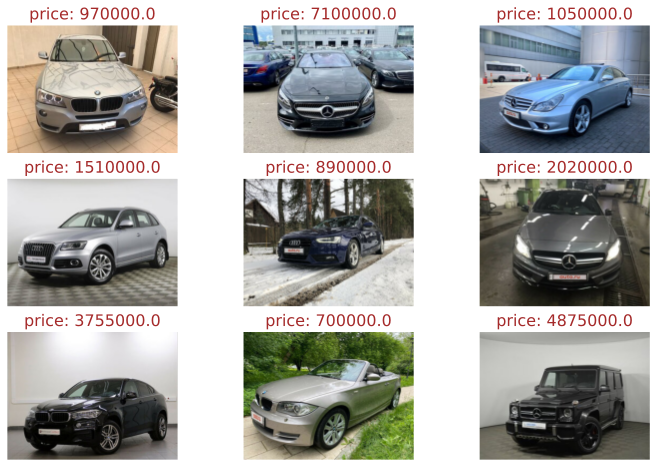

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR + 'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]), color='brown')
    plt.axis('off')
plt.show()

### Data

In [ ]:
IMG_SIZE = (320, 240)
# IMG_SIZE = (128, 96)
# IMG_SIZE = (64, 48)


def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, IMG_SIZE)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5813, 240, 320, 3) dtype uint8
images shape (869, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### Images Augmentation

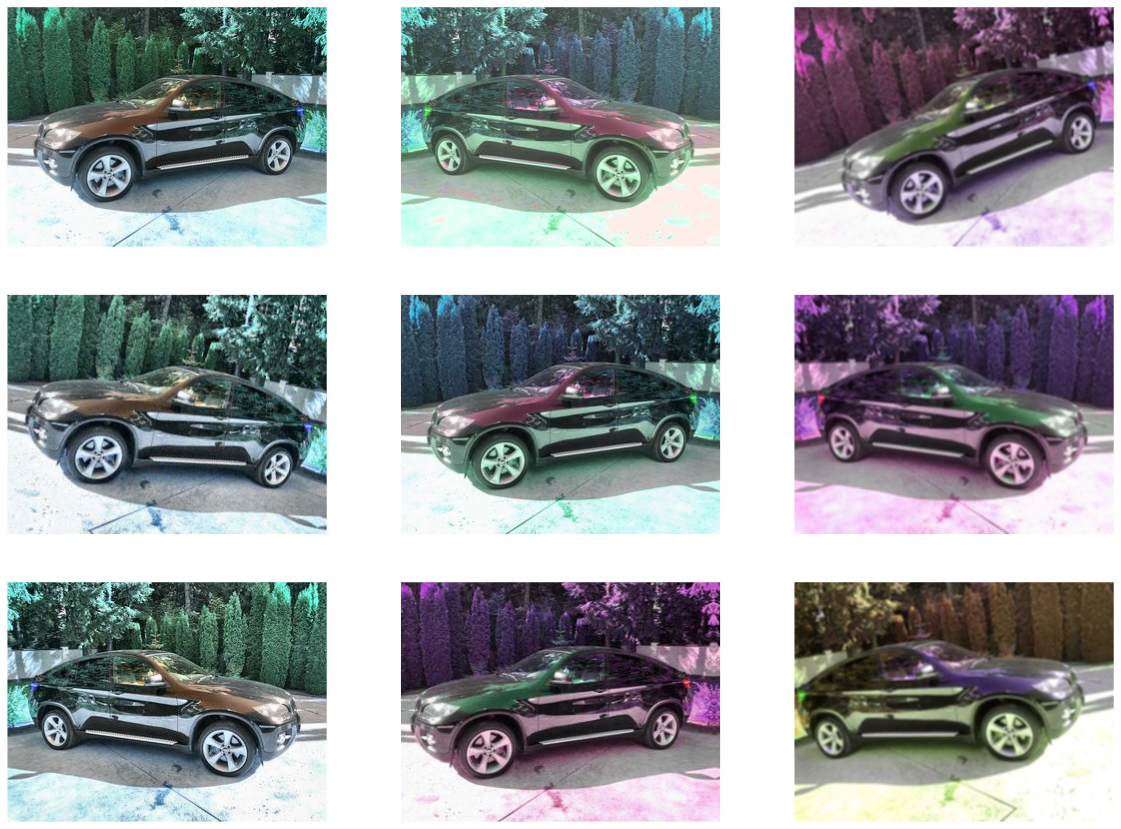

In [ ]:
# Используем аугментацию изображений для повышения качества распознавания
# Настраиваем аугментации посредством пакета albumentations

import albumentations as A

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5), 

    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                       rotate_limit=15, p=0.5), 

    A.OneOf([A.RandomBrightnessContrast(brightness_limit=0.25, 
                                        contrast_limit=0.25), 
             A.RandomBrightnessContrast(brightness_limit=0.1, 
                                        contrast_limit=0.1)], p=0.2),
    
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, 
                         val_shift_limit=0, p=0.5),
    
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, 
               b_shift_limit=10, p=0.3), 
    
    A.ChannelShuffle(p=0.5), 

    A.RandomGamma(p=0.2),
    
    A.CLAHE(clip_limit=2, p=0.3), 

    A.GaussNoise(p=0.15), 
    
    A.Blur(blur_limit=3, p=0.2)
])

fig_size = tuple(v / 16 for v in IMG_SIZE) # (18, 12)
plt.figure(figsize=fig_size)
for i in range(9):
    img = augmentation(image=images_train[4])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Data Generating Conveyor
Создаем генераторы конвеерной подачи данных для оптимизации использования вычислительных ресурсов

In [ ]:
# NLP-часть
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_descr.description)

In [ ]:
# Токенизация 
def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), 
                                maxlen=MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
  return tokenize_([text.numpy().decode('utf-8')])[0]

# Аугментирование изображений
def process_image(image):
  return augmentation(image=image.numpy())['image']


# Конвеерная обработка данных
def tf_process_train_dataset_element(image, table_data, text, price):
  im_shape = image.shape
  [image] = tf.py_function(process_image, [image], [tf.uint8])
  image.set_shape(im_shape)
  [text] = tf.py_function(tokenize_text, [text], [tf.int32])
  return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
  [text] = tf.py_function(tokenize_text, [text], [tf.int32])
  return (image, table_data, text), price


# устанавливаем генераторы датасетов:
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, df_descr.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, df_descr.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, df_descr.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

# проверяем на отсутствие ошибок:
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Pretrained CNN
Строим сверточную сеть для анализа изображений

In [ ]:
from tensorflow.keras.applications import efficientnet as efn

# нормализация включена в состав модели EfficientNet
efficientnet_model = efn.EfficientNetB6(weights='imagenet', 
                                        include_top=False, 
                                        input_shape=(IMG_SIZE[1], IMG_SIZE[0], 3))

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

## Assembling Models

Используем также уже разработанные табличную и NLP нейросети

In [ ]:
# Tabular NN
tabular_model = rebuild_nn1()

# NLP NN
nlp_model = rebuild_nn2()

Компонуем все 3 модели, применяя технику Fine-tuning к предобученной сети EfficientNet

In [ ]:
# Отключаем обучаемость efficientnet-модели
efficientnet_model.trainable = False

# Создаем комбинированный входной слой из выходов всех трех моделей
combinedInput = L.concatenate([efficientnet_output, 
                               tabular_model.output, 
                               nlp_model.output])

# Задаем архитектуру "головы"
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1)(head)


# Собираем модель
model = Model(inputs=[efficientnet_model.input, 
                      tabular_model.input, 
                      nlp_model.input], 
              outputs=head)

## Fit

Завернем некоторые процедуры Fine-tuning в функции для удобства в реализации дальнейших шагов:

In [ ]:
def model_save(model, step=0):
  '''
  Сохраняет результаты последнего шага обучения
  '''
  model.load_weights(WORK_DIR + 'best_model.hdf5')
  model.save(WORK_DIR + f'nn_final_step{step}.hdf5')

def model_evaluate(model):
  nn3_pred = restore_price(model.predict(test_dataset.batch(BATCH_SIZE)), *price_mutator)
  nn3_test = restore_price(y_test, *price_mutator)
  print(f'TEST mape: {(mape(nn3_test, nn3_pred)) * 100: .2f}%')


def model_layers_info(model):
  '''
  Показывает количество слоев в модели, а также
  состояние открытости к обучению каждого слоя
  (✔️ - готов к обучению, ✖️ - заморожен)
  '''
  print(f'Model <{model._name}> layers count:', len(model.layers), 
        f'(trainable vars: {len(model.trainable_variables)})', end='\n\n')
  
  for i in range(len(model.layers)):
      l = model.layers[i]
      print(f'{i + 1:03}', f'✔️' if l.trainable else '✖️', l.name)

def finetune(base_model, n, model, opt):
  '''
  Реализует шаг Fine-tuning, размораживая 'n' последних слоев у 
  'base_model' (BatchNorm-слои остаются нетронутыми).
  После этого модель 'model' компилируется в соответствии 
  с указанным оптимизатором 'opt'.
  '''
  # Отключаем обучаемость всей base_model
  base_model.trainable = False
  # Размораживаем n последних слоев
  for layer in base_model.layers[-n:]:
    layer.trainable = True
  
  model.compile(loss='MAPE', 
                optimizer=opt, 
                metrics=['MAPE'])

In [ ]:
BATCH_SIZE = 30
LR = 0.005


# Компилируем
optimizer = tf.keras.optimizers.Adam(LR, amsgrad=True)

model.compile(loss='MAPE', 
              optimizer=optimizer, 
              metrics=['MAPE'])

# Проверим результат
model_layers_info(model)

In [ ]:
# Обучаем
history = model.fit(train_dataset.batch(BATCH_SIZE), 
                    epochs=50, 
                    validation_data=test_dataset.batch(BATCH_SIZE), 
                    callbacks=recreate_callbacks(use_scheduler=False))

plot_history(history)

In [ ]:
model_save(model, step=1)
model_evaluate(model)

## Step 2
На втором шаге разморозим половину слоев efficientnet_model и дообучим модель с уменьшенной Learning Rate.

In [ ]:
LR = 0.0005


finetune(efficientnet_model, 
         int(len(efficientnet_model.layers) // 2),  # размораживаем половину слоев
         model=model, 
         opt=optimizer)

In [ ]:
# Посмотрим количество слоев и их статус обучаемости
model_layers_info(model)

In [ ]:
model.load_weights(WORK_DIR + 'best_model.hdf5')

# Обучаем
history = model.fit(train_dataset.batch(BATCH_SIZE), 
                    epochs=50, 
                    validation_data=test_dataset.batch(BATCH_SIZE), 
                    callbacks=recreate_callbacks(use_scheduler=False))

plot_history(history)

In [ ]:
model_save(model, step=2)
model_evaluate(model)

## Step 3
На третьем шаге разморозим все слои base_model и еще уменьшим Learning rate. Теперь обучаем с включенным Learning Rate Scheduler


In [ ]:
LR = 0.0001


finetune(efficientnet_model, 
         int(len(efficientnet_model.layers)), 
         model=model, 
         opt=optimizer)

In [ ]:
# Посмотрим количество слоев и их статус обучаемости
model_layers_info(model)

In [ ]:
model.load_weights(WORK_DIR + 'best_model.hdf5')

# Обучаем
history = model.fit(train_dataset.batch(BATCH_SIZE), 
                    epochs=50, 
                    validation_data=test_dataset.batch(BATCH_SIZE), 
                    callbacks=recreate_callbacks(use_scheduler=True))

plot_history(history)

In [ ]:
model_save(model, step=3)
model_evaluate(model)

# Предсказание на тестовых данных

In [ ]:
sub_predict_nn3 = restore_price(model.predict(sub_dataset.batch(BATCH_SIZE)), *price_mutator)
sample_submission['price'] = sub_predict_nn3
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [ ]:
test_predict_nn3 = restore_price(model.predict(test_dataset.batch(BATCH_SIZE)), 
                                 *price_mutator)
blend_test = restore_price(y_test, *price_mutator)
# blend_pred = (cat_pred + nn1_pred) / 2
# blend_pred = (cat_pred + nn2_pred) / 2
# blend_pred = (cat_pred + nn1_pred + nn2_pred) / 3
blend_pred = (cat_pred + test_predict_nn3) / 2

print(f"TEST mape: {(mape(blend_test, blend_pred)) * 100: .2f}%")

TEST mape:  10.11%


In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

### Final Notes and Thoughts
- В некоторых случаях хорошо сработал оптимизатор Adamax, в других - Adam с параметром amsgrad=True;
- Была подобрана оптимальная Learning Rate для каждого случая;
Используется техника управления LR LearningRateScheduler там, где это дает пользу;
- Хорошо себя показала архитектура EfficientNet B6 с техникой Fine-tuning.
- NLP проработка и адаптация текста (лемматизация, bag of words, tfidf, etc.) не дали в этом кейсе существенного прироста score;
- Работа с таргетом - логарифмизация, нормализация, - не дала улучшения результата, а только значительно ухудшала его на нейросетях.


Что не успел, но хотелось бы попробовать:
- Появились идеи по совмещению NLP tokenization sequences с аугментированными через TF-IDF табличными данными, наверняка был был прирост при удачно подобранном vocabulary.